Processing dataset: train.csv
Loading data...
Date range in filtered data: 2023-07-08 00:00:00 to 2024-02-08 00:00:00
Dataset contains 216 unique dates from 2023-07-08 to 2024-02-08
Created 5 test periods:
  Period 1: 2024-01-05 to 2024-01-11
  Period 2: 2024-01-12 to 2024-01-18
  Period 3: 2024-01-19 to 2024-01-25
  Period 4: 2024-01-26 to 2024-02-01
  Period 5: 2024-02-02 to 2024-02-08

Period 1/5: 2024-01-05 to 2024-01-11
Initial training period: 2023-07-08 to 2024-01-04
Will forecast day-by-day for 7 days in this period

  Day 1/7: Predicting for 2024-01-05
    Training on data from 2023-07-08 to 2024-01-04
    Testing on 2024-01-05


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1365149 samples, testing on 7864 samples
    Day results - RMSE: 0.1291, MAE: 0.0882, R²: 0.9818, MAPE: 32.96%

  Day 2/7: Predicting for 2024-01-06
    Training on data from 2023-07-08 to 2024-01-05
    Testing on 2024-01-06


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1373013 samples, testing on 7864 samples
    Day results - RMSE: 0.1355, MAE: 0.0928, R²: 0.9796, MAPE: 40.62%

  Day 3/7: Predicting for 2024-01-07
    Training on data from 2023-07-08 to 2024-01-06
    Testing on 2024-01-07


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1380877 samples, testing on 7864 samples
    Day results - RMSE: 0.1814, MAE: 0.1219, R²: 0.9584, MAPE: 50.83%

  Day 4/7: Predicting for 2024-01-08
    Training on data from 2023-07-08 to 2024-01-07
    Testing on 2024-01-08


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1388741 samples, testing on 7864 samples
    Day results - RMSE: 0.1218, MAE: 0.0870, R²: 0.9808, MAPE: 30.86%

  Day 5/7: Predicting for 2024-01-09
    Training on data from 2023-07-08 to 2024-01-08
    Testing on 2024-01-09


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1396605 samples, testing on 7864 samples
    Day results - RMSE: 0.1244, MAE: 0.0826, R²: 0.9795, MAPE: 23.39%

  Day 6/7: Predicting for 2024-01-10
    Training on data from 2023-07-08 to 2024-01-09
    Testing on 2024-01-10


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1404469 samples, testing on 7864 samples
    Day results - RMSE: 0.1057, MAE: 0.0770, R²: 0.9852, MAPE: 18.67%

  Day 7/7: Predicting for 2024-01-11
    Training on data from 2023-07-08 to 2024-01-10
    Testing on 2024-01-11


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1412333 samples, testing on 7864 samples
    Day results - RMSE: 0.1028, MAE: 0.0763, R²: 0.9861, MAPE: 19.65%

Period 2/5: 2024-01-12 to 2024-01-18
Initial training period: 2023-07-08 to 2024-01-11
Will forecast day-by-day for 7 days in this period

  Day 1/7: Predicting for 2024-01-12
    Training on data from 2023-07-08 to 2024-01-11
    Testing on 2024-01-12


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1420197 samples, testing on 7864 samples
    Day results - RMSE: 0.1152, MAE: 0.0818, R²: 0.9833, MAPE: 36.69%

  Day 2/7: Predicting for 2024-01-13
    Training on data from 2023-07-08 to 2024-01-12
    Testing on 2024-01-13


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1428061 samples, testing on 7864 samples
    Day results - RMSE: 0.1066, MAE: 0.0760, R²: 0.9858, MAPE: 17.94%

  Day 3/7: Predicting for 2024-01-14
    Training on data from 2023-07-08 to 2024-01-13
    Testing on 2024-01-14


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1435925 samples, testing on 7864 samples
    Day results - RMSE: 0.1211, MAE: 0.0859, R²: 0.9805, MAPE: 22.09%

  Day 4/7: Predicting for 2024-01-15
    Training on data from 2023-07-08 to 2024-01-14
    Testing on 2024-01-15


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1443789 samples, testing on 7864 samples
    Day results - RMSE: 0.1184, MAE: 0.0805, R²: 0.9813, MAPE: 18.61%

  Day 5/7: Predicting for 2024-01-16
    Training on data from 2023-07-08 to 2024-01-15
    Testing on 2024-01-16


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1451653 samples, testing on 7864 samples
    Day results - RMSE: 0.1288, MAE: 0.0828, R²: 0.9783, MAPE: 19.73%

  Day 6/7: Predicting for 2024-01-17
    Training on data from 2023-07-08 to 2024-01-16
    Testing on 2024-01-17


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1459517 samples, testing on 7864 samples
    Day results - RMSE: 0.1147, MAE: 0.0797, R²: 0.9830, MAPE: 17.88%

  Day 7/7: Predicting for 2024-01-18
    Training on data from 2023-07-08 to 2024-01-17
    Testing on 2024-01-18


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1467381 samples, testing on 7864 samples
    Day results - RMSE: 0.1125, MAE: 0.0804, R²: 0.9838, MAPE: 22.28%

Period 3/5: 2024-01-19 to 2024-01-25
Initial training period: 2023-07-08 to 2024-01-18
Will forecast day-by-day for 7 days in this period

  Day 1/7: Predicting for 2024-01-19
    Training on data from 2023-07-08 to 2024-01-18
    Testing on 2024-01-19


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1475245 samples, testing on 7864 samples
    Day results - RMSE: 0.1290, MAE: 0.0873, R²: 0.9796, MAPE: 40.85%

  Day 2/7: Predicting for 2024-01-20
    Training on data from 2023-07-08 to 2024-01-19
    Testing on 2024-01-20


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1483109 samples, testing on 7864 samples
    Day results - RMSE: 0.1133, MAE: 0.0795, R²: 0.9844, MAPE: 19.44%

  Day 3/7: Predicting for 2024-01-21
    Training on data from 2023-07-08 to 2024-01-20
    Testing on 2024-01-21


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1490973 samples, testing on 7864 samples
    Day results - RMSE: 0.1256, MAE: 0.0882, R²: 0.9795, MAPE: 26.33%

  Day 4/7: Predicting for 2024-01-22
    Training on data from 2023-07-08 to 2024-01-21
    Testing on 2024-01-22


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1498837 samples, testing on 7864 samples
    Day results - RMSE: 0.1229, MAE: 0.0818, R²: 0.9802, MAPE: 18.98%

  Day 5/7: Predicting for 2024-01-23
    Training on data from 2023-07-08 to 2024-01-22
    Testing on 2024-01-23


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1506701 samples, testing on 7864 samples
    Day results - RMSE: 0.1083, MAE: 0.0778, R²: 0.9846, MAPE: 17.53%

  Day 6/7: Predicting for 2024-01-24
    Training on data from 2023-07-08 to 2024-01-23
    Testing on 2024-01-24


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1514565 samples, testing on 7864 samples
    Day results - RMSE: 0.1355, MAE: 0.0833, R²: 0.9764, MAPE: 20.13%

  Day 7/7: Predicting for 2024-01-25
    Training on data from 2023-07-08 to 2024-01-24
    Testing on 2024-01-25


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1522429 samples, testing on 7864 samples
    Day results - RMSE: 0.1105, MAE: 0.0794, R²: 0.9845, MAPE: 19.00%

Period 4/5: 2024-01-26 to 2024-02-01
Initial training period: 2023-07-08 to 2024-01-25
Will forecast day-by-day for 7 days in this period

  Day 1/7: Predicting for 2024-01-26
    Training on data from 2023-07-08 to 2024-01-25
    Testing on 2024-01-26


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1530293 samples, testing on 7864 samples
    Day results - RMSE: 0.1581, MAE: 0.0897, R²: 0.9708, MAPE: 42.83%

  Day 2/7: Predicting for 2024-01-27
    Training on data from 2023-07-08 to 2024-01-26
    Testing on 2024-01-27


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1538157 samples, testing on 7864 samples
    Day results - RMSE: 0.1370, MAE: 0.0801, R²: 0.9777, MAPE: 26.22%

  Day 3/7: Predicting for 2024-01-28
    Training on data from 2023-07-08 to 2024-01-27
    Testing on 2024-01-28


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1546021 samples, testing on 7864 samples
    Day results - RMSE: 0.1298, MAE: 0.0885, R²: 0.9781, MAPE: 23.36%

  Day 4/7: Predicting for 2024-01-29
    Training on data from 2023-07-08 to 2024-01-28
    Testing on 2024-01-29


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1553885 samples, testing on 7864 samples
    Day results - RMSE: 0.1119, MAE: 0.0792, R²: 0.9835, MAPE: 19.23%

  Day 5/7: Predicting for 2024-01-30
    Training on data from 2023-07-08 to 2024-01-29
    Testing on 2024-01-30


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1561749 samples, testing on 7864 samples
    Day results - RMSE: 0.1141, MAE: 0.0807, R²: 0.9824, MAPE: 20.31%

  Day 6/7: Predicting for 2024-01-31
    Training on data from 2023-07-08 to 2024-01-30
    Testing on 2024-01-31


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1569613 samples, testing on 7864 samples
    Day results - RMSE: 0.1060, MAE: 0.0761, R²: 0.9849, MAPE: 16.86%

  Day 7/7: Predicting for 2024-02-01
    Training on data from 2023-07-08 to 2024-01-31
    Testing on 2024-02-01


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1577477 samples, testing on 7864 samples
    Day results - RMSE: 0.1712, MAE: 0.0873, R²: 0.9634, MAPE: 23.76%

Period 5/5: 2024-02-02 to 2024-02-08
Initial training period: 2023-07-08 to 2024-02-01
Will forecast day-by-day for 7 days in this period

  Day 1/7: Predicting for 2024-02-02
    Training on data from 2023-07-08 to 2024-02-01
    Testing on 2024-02-02


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1585341 samples, testing on 7864 samples
    Day results - RMSE: 0.1393, MAE: 0.0894, R²: 0.9765, MAPE: 36.94%

  Day 2/7: Predicting for 2024-02-03
    Training on data from 2023-07-08 to 2024-02-02
    Testing on 2024-02-03


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1593205 samples, testing on 7864 samples
    Day results - RMSE: 0.1189, MAE: 0.0795, R²: 0.9830, MAPE: 18.03%

  Day 3/7: Predicting for 2024-02-04
    Training on data from 2023-07-08 to 2024-02-03
    Testing on 2024-02-04


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1601069 samples, testing on 7864 samples
    Day results - RMSE: 0.1302, MAE: 0.0880, R²: 0.9782, MAPE: 27.90%

  Day 4/7: Predicting for 2024-02-05
    Training on data from 2023-07-08 to 2024-02-04
    Testing on 2024-02-05


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1608933 samples, testing on 7864 samples
    Day results - RMSE: 0.1205, MAE: 0.0813, R²: 0.9813, MAPE: 17.97%

  Day 5/7: Predicting for 2024-02-06
    Training on data from 2023-07-08 to 2024-02-05
    Testing on 2024-02-06


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1616797 samples, testing on 7864 samples
    Day results - RMSE: 0.1393, MAE: 0.0814, R²: 0.9755, MAPE: 17.83%

  Day 6/7: Predicting for 2024-02-07
    Training on data from 2023-07-08 to 2024-02-06
    Testing on 2024-02-07


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1624661 samples, testing on 7864 samples
    Day results - RMSE: 0.1226, MAE: 0.0790, R²: 0.9811, MAPE: 17.55%

  Day 7/7: Predicting for 2024-02-08
    Training on data from 2023-07-08 to 2024-02-07
    Testing on 2024-02-08


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


    Training on 1632525 samples, testing on 7864 samples
    Day results - RMSE: 0.1186, MAE: 0.0792, R²: 0.9824, MAPE: 17.58%
Results saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Topic2_HybridCVDayAhead\xgboost_hybrid_cv_day_ahead_results.csv
Period metrics saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Topic2_HybridCVDayAhead\xgboost_hybrid_cv_day_ahead_period_metrics.csv
Daily metrics saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Topic2_HybridCVDayAhead\xgboost_hybrid_cv_day_ahead_daily_metrics.csv
Feature importance saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Topic2_HybridCVDayAhead\xgboost_hybrid_cv_day_ahead_feature_importance.csv

===== HYBRID CV + DAY-AHEAD XGBOOST MODEL EVALUATION =====

=== Overall Metrics ===
RMSE: 0.1263
MAE: 0.0837
R²: 0.9798
MAPE: 24.5950%
Explained Variance: 0.9803
Median Abs Error: 0.0712

=== Period Performance ===
 period     rmse      mae      mape       r2  n_samples
 

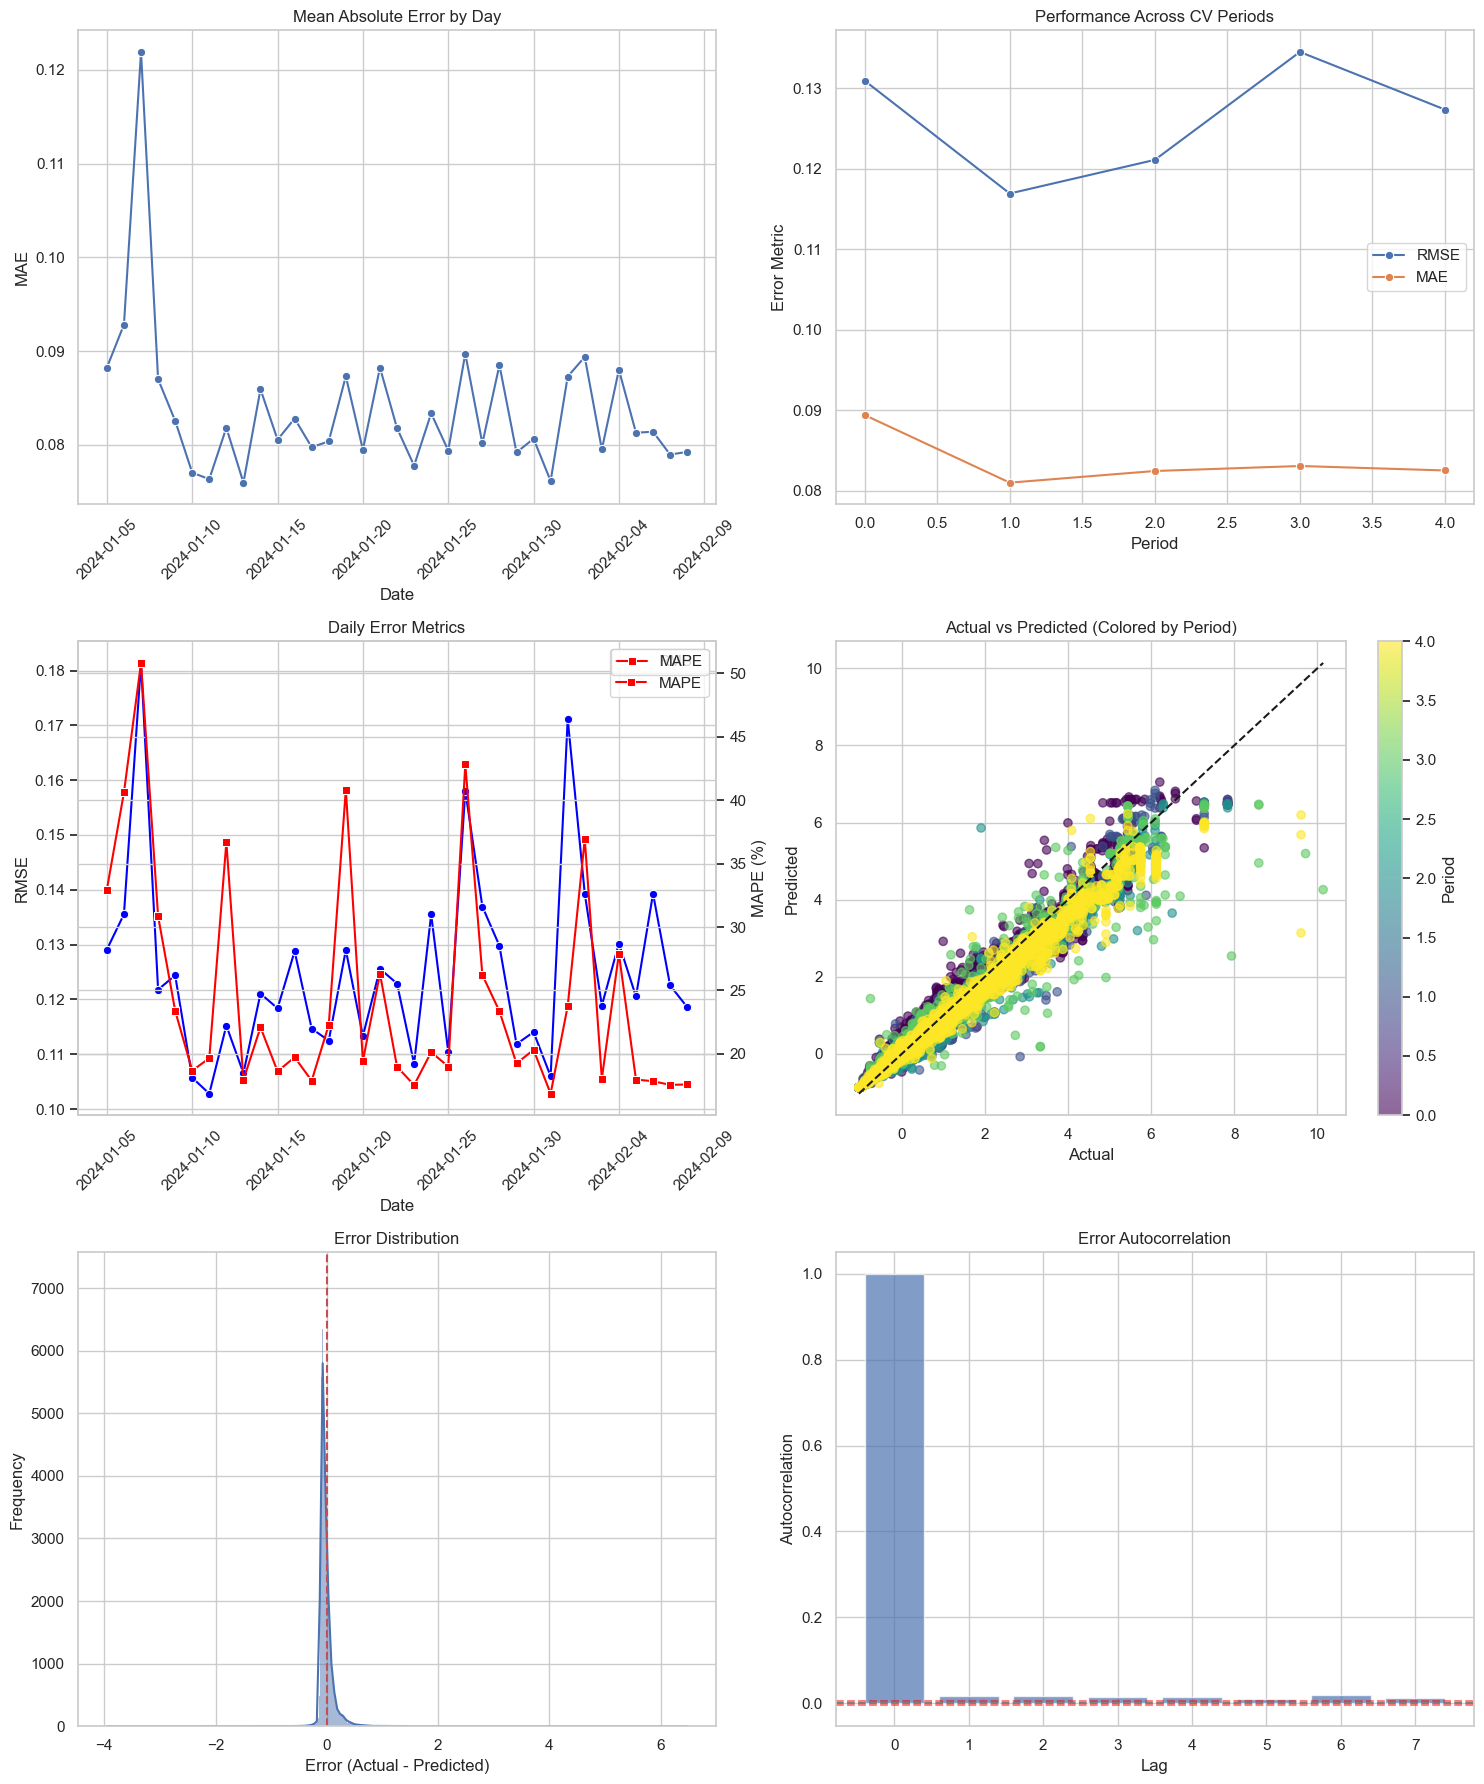

C:\Users\mvk\AppData\Local\Temp\ipykernel_4296\1336687431.py:666: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


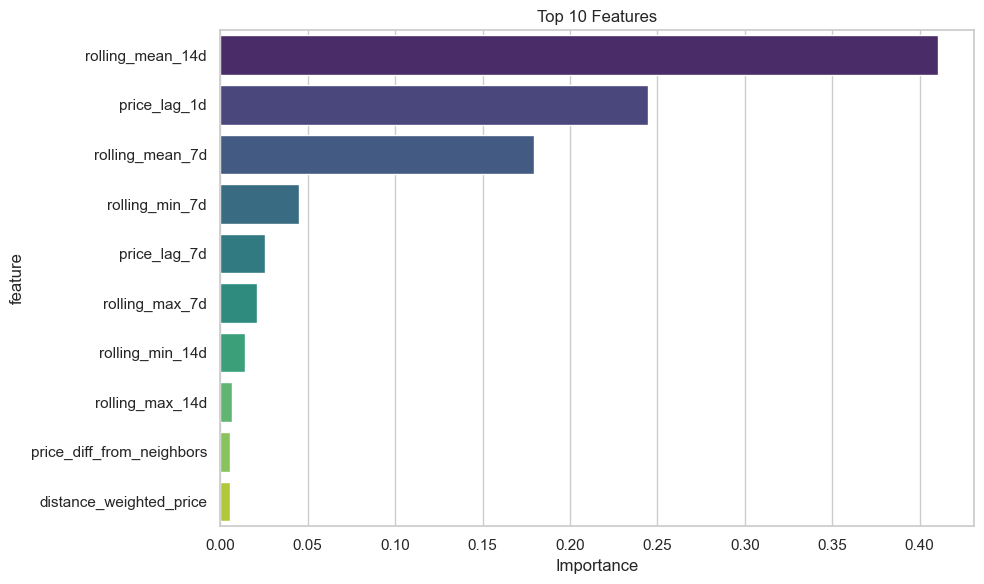

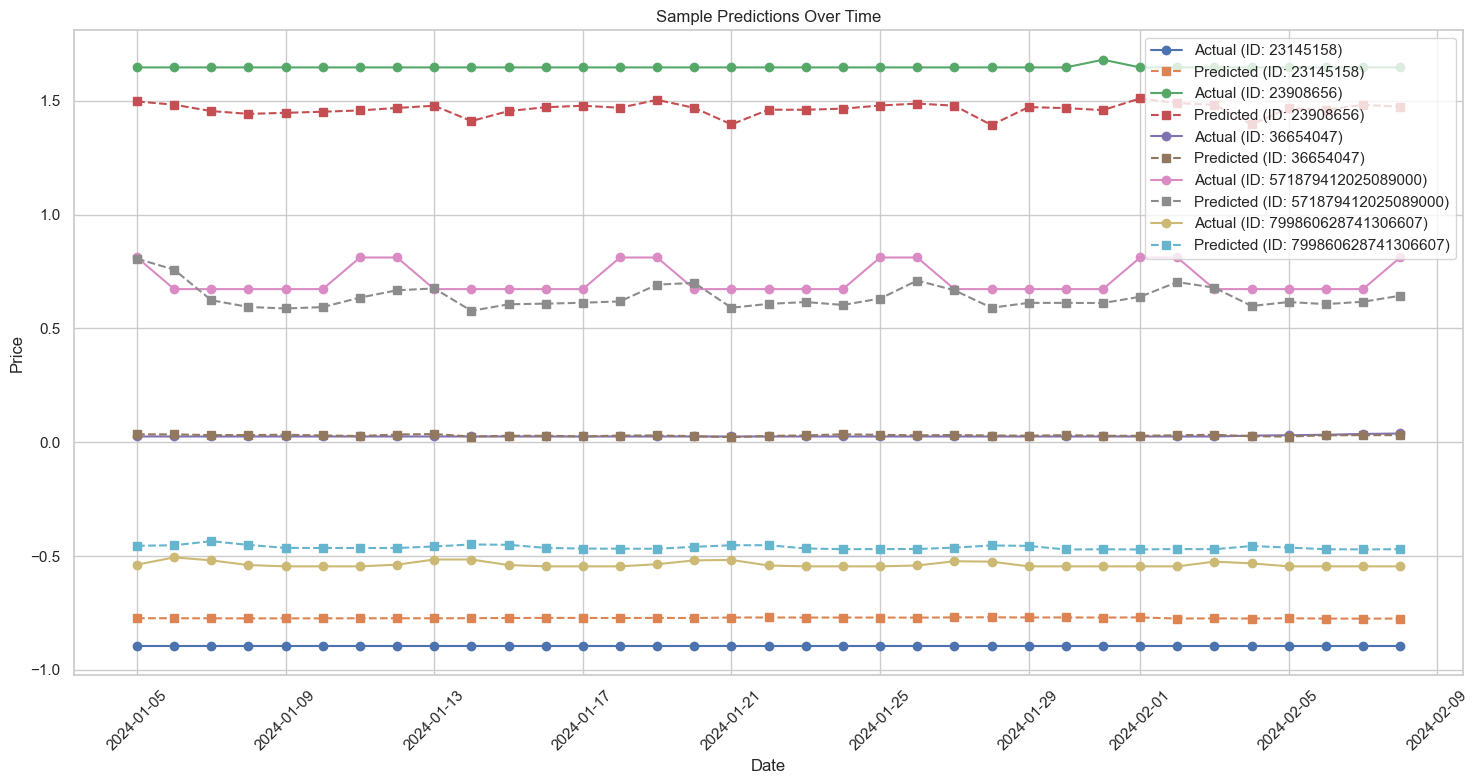

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from math import radians, sin, cos, sqrt, atan2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, median_absolute_error
from scipy.stats import linregress
from statsmodels.tsa.stattools import acf
from sklearn.neighbors import BallTree
from xgboost import XGBRegressor
from joblib import Parallel, delayed
import math
import warnings
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit

def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points using the Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def create_spatial_features(df, k_neighbors=5, chunk_size=1000, n_jobs=-1):
    """Enhanced spatial features while maintaining existing structure"""
    # Adjust k_neighbors if the dataset is small
    actual_k = min(k_neighbors, len(df) - 1)  # Make sure k is at most n-1
    if actual_k < k_neighbors:
        print(f"Reducing k_neighbors from {k_neighbors} to {actual_k} due to small sample size")
    
    city_center_lat, city_center_lon = 48.8566, 2.3522
    
    # Keep existing spatial features
    spatial_data = {
        'distance_to_center': [],
        'north_south': [],
        'knn_price_mean': [],
        'knn_price_std': [],
        'price_diff_from_neighbors': []
    }
    
    # Add new spatial features
    spatial_data.update({
        'knn_price_median': [],  # Add median as more robust metric
        'knn_price_range': [],   # Add price range in neighborhood
        'distance_weighted_price': []  # Add distance-weighted price
    })
    
    # Calculate basic distance features (keeping existing logic)
    spatial_data['distance_to_center'] = df.apply(
        lambda row: calculate_distance(
            row['latitude'], 
            row['longitude'], 
            city_center_lat, 
            city_center_lon
        ),
        axis=1
    ).values
    
    spatial_data['north_south'] = (df['latitude'] - city_center_lat).values
    
    # Enhanced BallTree processing
    all_coords = np.radians(df[['latitude', 'longitude']].values)
    tree = BallTree(all_coords, metric='haversine')
    all_prices = df['price'].values
    
    def enhanced_process_chunk(chunk_data, tree, k_neighbors, all_prices):
        """Enhanced chunk processing with additional metrics"""
        coords = np.radians(chunk_data[['latitude', 'longitude']].values)
        # Use adaptive k value
        k_query = min(k_neighbors + 1, len(all_coords))
        distances, indices = tree.query(coords, k=k_query)
        
        # If k_query is 1, we need special handling
        if k_query == 1:
            # Just return zeros or appropriate values for a single point
            n_samples = len(chunk_data)
            return {
                'knn_price_mean': np.zeros(n_samples),
                'knn_price_std': np.zeros(n_samples),
                'knn_price_median': np.zeros(n_samples),
                'knn_price_range': np.zeros(n_samples),
                'price_diff_from_neighbors': np.zeros(n_samples),
                'distance_weighted_price': np.zeros(n_samples)
            }
        
        # Process neighbor data if we have multiple points
        # Handle the case where k_query is 2 (self + 1 neighbor)
        if k_query == 2:
            neighbor_prices = np.take(all_prices, indices[:, 1:]).reshape(-1, 1)
            weights = np.ones((len(distances), 1))  # Only one neighbor, so weight is 1
        else:
            # Convert distances to weights (inverse distance weighting)
            weights = 1 / (distances[:, 1:] + 1e-6)  # Add small epsilon to avoid division by zero
            weights = weights / weights.sum(axis=1, keepdims=True)
            neighbor_prices = np.take(all_prices, indices[:, 1:])
        
        # Calculate neighbor statistics
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)  # Ignore NaN warnings
            mean_prices = np.nanmean(neighbor_prices, axis=1)
            std_prices = np.nanstd(neighbor_prices, axis=1)
            
            # Handle single-neighbor case for median and range
            if neighbor_prices.shape[1] == 1:
                median_prices = neighbor_prices.flatten()
                range_prices = np.zeros(len(neighbor_prices))
            else:
                median_prices = np.nanmedian(neighbor_prices, axis=1)
                range_prices = np.ptp(neighbor_prices, axis=1)
            
            # Weighted prices
            if neighbor_prices.shape[1] == 1:
                weighted_prices = neighbor_prices.flatten()
            else:
                weighted_prices = np.sum(weights * neighbor_prices, axis=1)
        
        return {
            'knn_price_mean': mean_prices,
            'knn_price_std': std_prices,
            'knn_price_median': median_prices,
            'knn_price_range': range_prices,
            'price_diff_from_neighbors': chunk_data['price'].values - mean_prices,
            'distance_weighted_price': weighted_prices
        }
    
    # Split and process chunks (keeping existing logic)
    n_chunks = math.ceil(len(df) / chunk_size)
    chunks = np.array_split(df, n_chunks)
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(enhanced_process_chunk)(
            chunk, 
            tree, 
            actual_k,  # Use adjusted k value
            all_prices
        ) for chunk in chunks
    )
    
    # Combine results with new features
    for key in spatial_data.keys():
        if key not in ['distance_to_center', 'north_south']:
            spatial_data[key] = np.concatenate([r[key] for r in results])
    
    spatial_features = pd.DataFrame(spatial_data, index=df.index)
    
    # Enhanced feature standardization
    features_to_standardize = list(spatial_data.keys())
    
    for col in features_to_standardize:
        mean_val = spatial_features[col].mean()
        std_val = spatial_features[col].std()
        # Avoid division by zero
        if std_val > 0:
            spatial_features[col] = (spatial_features[col] - mean_val) / std_val
        else:
            spatial_features[col] = 0  # Set to zero if std is zero
    
    return spatial_features

def run_hybrid_cv_day_ahead_xgboost(train_path, output_dir=None, n_splits=5, sample_size=None):
    """
    Run XGBoost with a hybrid approach: cross-validation periods + day-ahead forecasting.
    
    Parameters:
    -----------
    train_path : str
        Path to the training data CSV file
    output_dir : str, optional
        Directory to save results
    n_splits : int, optional
        Number of splits for time series cross-validation (each 7 days)
    sample_size : int, optional
        Limit dataset to this number of random listings (for testing)
    """
    print(f"Processing dataset: {os.path.basename(train_path)}")
    
    # Load training data
    print("Loading data...")
    train_data = pd.read_csv(train_path)
    
    # For testing - take only a small sample of listings if specified
    if sample_size:
        unique_listings = train_data['listing_id'].unique()
        if len(unique_listings) > sample_size:
            print(f"Limiting to {sample_size} random listings for testing")
            selected_listings = np.random.choice(unique_listings, sample_size, replace=False)
            train_data = train_data[train_data['listing_id'].isin(selected_listings)]
    
    # Convert date column to datetime
    train_data['date'] = pd.to_datetime(train_data['date'])
    
    # Filter data to include only dates from 7/8/23 till 2/8/24 (as specified)
    start_date = pd.to_datetime('2023-07-08')
    end_date = pd.to_datetime('2024-02-08')
    train_data = train_data[(train_data['date'] >= start_date) & (train_data['date'] <= end_date)]
    
    # Sort by date
    train_data = train_data.sort_values('date')
    
    print(f"Date range in filtered data: {train_data['date'].min()} to {train_data['date'].max()}")
    
    # Get unique dates
    unique_dates = sorted(train_data['date'].dt.date.unique())
    print(f"Dataset contains {len(unique_dates)} unique dates from {unique_dates[0]} to {unique_dates[-1]}")
    
    # Create explicit test periods - last 5 weeks (35 days) split into 5 equal parts (7 days each)
    last_35_days = unique_dates[-35:]
    
    # Define explicit test periods - each 7 days
    test_periods = []
    for i in range(n_splits):
        start_idx = i * 7
        end_idx = start_idx + 7
        # Make sure we don't go beyond the available data
        if end_idx <= len(last_35_days):
            test_periods.append((last_35_days[start_idx], last_35_days[end_idx-1]))
    
    # Adjust n_splits if we couldn't create enough test periods
    n_splits = len(test_periods)
    
    print(f"Created {n_splits} test periods:")
    for i, (test_start, test_end) in enumerate(test_periods):
        print(f"  Period {i+1}: {test_start} to {test_end}")
    
    # Initialize XGBoost model
    xgb_model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.01,
        max_depth=6,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        early_stopping_rounds=20,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1,
        tree_method='hist',
        grow_policy='lossguide'
    )
    
    # Storage for results
    cv_results = []
    feature_importance_over_time = []
    
    # Run time series cross-validation using our explicit test periods
    for period_idx, (period_start, period_end) in enumerate(test_periods):
        print(f"\nPeriod {period_idx+1}/{n_splits}: {period_start} to {period_end}")
        
        # Define initial training cutoff - everything before period_start
        initial_train_end = pd.to_datetime(period_start) - pd.Timedelta(days=1)
        initial_train_end_date = initial_train_end.date()
        
        print(f"Initial training period: {unique_dates[0]} to {initial_train_end_date}")
        
        # Get all test dates in this period
        period_dates = [d for d in unique_dates if period_start <= d <= period_end]
        print(f"Will forecast day-by-day for {len(period_dates)} days in this period")
        
        # For each day in the period, forecast one day ahead and then retrain
        for day_idx, test_date in enumerate(period_dates):
            print(f"\n  Day {day_idx+1}/{len(period_dates)}: Predicting for {test_date}")
            
            # Define current cutoff date for training (all data before test_date)
            if day_idx == 0:
                # For first day of period, use initial training data
                train_cutoff = initial_train_end_date
            else:
                # For subsequent days, include all days up to previous test day
                train_cutoff = period_dates[day_idx - 1]
            
            # All data up to (and including) train_cutoff
            train_mask = train_data['date'].dt.date <= train_cutoff
            test_mask = train_data['date'].dt.date == test_date
            
            # Skip if no test data for this day
            if not any(test_mask):
                print(f"    No data available for testing on {test_date}, skipping...")
                continue
                
            # Skip if no training data
            if not any(train_mask):
                print(f"    No training data available before {test_date}, skipping...")
                continue
            
            split_train_data = train_data[train_mask]
            split_test_data = train_data[test_mask]
            
            print(f"    Training on data from {split_train_data['date'].dt.date.min()} to {split_train_data['date'].dt.date.max()}")
            print(f"    Testing on {test_date}")
            
            # Create spatial features for training and test data
            train_spatial = create_spatial_features(split_train_data)
            test_spatial = create_spatial_features(split_test_data)
            
            # Prepare feature matrices
            X_train = pd.concat([
                split_train_data.drop(['listing_id', 'date', 'price'], axis=1), 
                train_spatial
            ], axis=1)
            
            X_test = pd.concat([
                split_test_data.drop(['listing_id', 'date', 'price'], axis=1), 
                test_spatial
            ], axis=1)
            
            y_train = split_train_data['price']
            y_test = split_test_data['price']
            
            # Ensure X_train and X_test have the same columns
            missing_cols = set(X_train.columns) - set(X_test.columns)
            for col in missing_cols:
                X_test[col] = 0
                
            # Ensure the columns are in the same order
            X_test = X_test[X_train.columns]
            
            # Train the model
            print(f"    Training on {len(X_train)} samples, testing on {len(X_test)} samples")
            xgb_model.fit(
                X_train, 
                y_train,
                eval_set=[(X_train, y_train)],
                verbose=False
            )
            
            # Make predictions
            y_pred = xgb_model.predict(X_test)
            
            # Store feature importance
            feature_importance = pd.DataFrame({
                'feature': X_train.columns,
                'importance': xgb_model.feature_importances_,
                'period': period_idx,
                'day': day_idx
            })
            feature_importance_over_time.append(feature_importance)
            
            # Calculate metrics for this day
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred) if len(set(y_test)) > 1 else np.nan
            with np.errstate(divide='ignore', invalid='ignore'):
                mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
            
            print(f"    Day results - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")
            
            # Store results for this day
            day_results = pd.DataFrame({
                'period': period_idx,
                'day': day_idx,
                'date': split_test_data['date'],
                'listing_id': split_test_data['listing_id'],
                'price': y_test,
                'predicted': y_pred,
                'error': y_test - y_pred,
                'abs_error': np.abs(y_test - y_pred),
                'pct_error': np.abs((y_test - y_pred) / (y_test + 1e-8)) * 100
            })
            
            cv_results.append(day_results)
    
    # Combine all results
    all_results = pd.concat(cv_results, ignore_index=True)
    all_feature_importance = pd.concat(feature_importance_over_time, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['price']
    y_pred = all_results['predicted']
    
    overall_metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100,
        'explained_variance': explained_variance_score(y_true, y_pred),
        'max_error': max_error(y_true, y_pred),
        'median_absolute_error': median_absolute_error(y_true, y_pred)
    }
    
    # Calculate period-level metrics
    period_metrics = []
    for period in range(n_splits):
        period_data = all_results[all_results['period'] == period]
        if not period_data.empty:
            y_true_period = period_data['price']
            y_pred_period = period_data['predicted']
            
            period_metrics.append({
                'period': period,
                'rmse': np.sqrt(mean_squared_error(y_true_period, y_pred_period)),
                'mae': mean_absolute_error(y_true_period, y_pred_period),
                'r2': r2_score(y_true_period, y_pred_period) if len(set(y_true_period)) > 1 else np.nan,
                'mape': np.mean(np.abs((y_true_period - y_pred_period) / (y_true_period + 1e-8))) * 100,
                'n_samples': len(y_true_period)
            })
    
    period_metrics_df = pd.DataFrame(period_metrics)
    
    # Calculate daily metrics
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
    
    daily_metrics = []
    for day, group in all_results.groupby('date_str'):
        y_true_day = group['price']
        y_pred_day = group['predicted']
        
        daily_metrics.append({
            'date': day,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (y_true_day + 1e-8))) * 100,
            'n_samples': len(y_true_day)
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    daily_metrics_df['date'] = pd.to_datetime(daily_metrics_df['date'])
    daily_metrics_df = daily_metrics_df.sort_values('date')
    
    # Error analysis
    errors = all_results['error'].values
    error_autocorr = acf(errors, nlags=7)[1:]  # Exclude lag 0
    
    # Create a results dictionary
    evaluation_results = {
        'overall_metrics': overall_metrics,
        'period_metrics': period_metrics_df,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results,
        'feature_importance': all_feature_importance,
        'error_autocorrelation': error_autocorr
    }
    
    # Save results if output directory is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        
        # Save all results
        results_file = os.path.join(output_dir, 'xgboost_hybrid_cv_day_ahead_results.csv')
        all_results.to_csv(results_file, index=False)
        print(f"Results saved to {results_file}")
        
        # Save metrics
        period_metrics_file = os.path.join(output_dir, 'xgboost_hybrid_cv_day_ahead_period_metrics.csv')
        period_metrics_df.to_csv(period_metrics_file, index=False)
        print(f"Period metrics saved to {period_metrics_file}")
        
        daily_metrics_file = os.path.join(output_dir, 'xgboost_hybrid_cv_day_ahead_daily_metrics.csv')
        daily_metrics_df.to_csv(daily_metrics_file, index=False)
        print(f"Daily metrics saved to {daily_metrics_file}")
        
        # Save feature importance
        importance_file = os.path.join(output_dir, 'xgboost_hybrid_cv_day_ahead_feature_importance.csv')
        all_feature_importance.to_csv(importance_file, index=False)
        print(f"Feature importance saved to {importance_file}")
        
        # Save summary
        with open(os.path.join(output_dir, 'summary.txt'), 'w') as f:
            f.write(f"XGBoost Hybrid CV + Day-Ahead Model Summary\n")
            f.write(f"=====================================\n\n")
            f.write(f"Number of periods: {n_splits}\n")
            f.write(f"Initial training period: {unique_dates[0]} to {unique_dates[-35-1]}\n")
            f.write(f"Testing period: {unique_dates[-35]} to {unique_dates[-1]}\n\n")
            f.write(f"Overall Metrics:\n")
            for k, v in overall_metrics.items():
                f.write(f"  {k}: {v:.6f}\n")
    
    # Print summary and create plots
    print_hybrid_cv_day_ahead_summary(evaluation_results)
    plot_hybrid_cv_day_ahead_results(evaluation_results)
    
    return evaluation_results

def print_hybrid_cv_day_ahead_summary(evaluation_results):
    """Print a summary of hybrid CV + day-ahead forecasting results"""
    overall = evaluation_results['overall_metrics']
    periods = evaluation_results['period_metrics']
    daily = evaluation_results['daily_metrics']
    feature_importance = evaluation_results['feature_importance']
    error_autocorr = evaluation_results.get('error_autocorrelation', [0] * 7)
    
    print("\n===== HYBRID CV + DAY-AHEAD XGBOOST MODEL EVALUATION =====")
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    print(f"Explained Variance: {overall['explained_variance']:.4f}")
    print(f"Median Abs Error: {overall['median_absolute_error']:.4f}")
    
    print("\n=== Period Performance ===")
    print(periods[['period', 'rmse', 'mae', 'mape', 'r2', 'n_samples']].to_string(index=False))
    
    print("\n=== Period Statistics ===")
    print("MAE:")
    print(f"  Average: {periods['mae'].mean():.4f}")
    print(f"  Min: {periods['mae'].min():.4f} (Period {periods.loc[periods['mae'].idxmin(), 'period']})")
    print(f"  Max: {periods['mae'].max():.4f} (Period {periods.loc[periods['mae'].idxmax(), 'period']})")
    
    print("\nRMSE:")
    print(f"  Average: {periods['rmse'].mean():.4f}")
    print(f"  Min: {periods['rmse'].min():.4f} (Period {periods.loc[periods['rmse'].idxmin(), 'period']})")
    print(f"  Max: {periods['rmse'].max():.4f} (Period {periods.loc[periods['rmse'].idxmax(), 'period']})")
    
    print("\n=== Daily Performance ===")
    # Print a sample of the daily metrics (first 5 days, last 5 days)
    if len(daily) > 10:
        print("First 5 days:")
        print(daily.head(5)[['date', 'rmse', 'mae', 'mape', 'r2', 'n_samples']].to_string(index=False))
        print("\nLast 5 days:")
        print(daily.tail(5)[['date', 'rmse', 'mae', 'mape', 'r2', 'n_samples']].to_string(index=False))
    else:
        print(daily[['date', 'rmse', 'mae', 'mape', 'r2', 'n_samples']].to_string(index=False))
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    # Calculate overall feature importance by averaging across days and periods
    avg_importance = feature_importance.groupby('feature')['importance'].mean().reset_index()
    top_features = avg_importance.sort_values('importance', ascending=False).head(10)
    
    print("\n=== Top 10 Most Important Features ===")
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"{i}. {row['feature']}: {row['importance']:.6f}")

def plot_hybrid_cv_day_ahead_results(evaluation_results):
    """Plot the results from hybrid CV + day-ahead forecasting"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    period_metrics = evaluation_results['period_metrics']
    all_results = evaluation_results['all_results']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[0, 0].xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Show every 5 days
    plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Period Metrics
    periods_x = period_metrics['period']
    metrics_to_plot = ['rmse', 'mae']
    
    for metric in metrics_to_plot:
        sns.lineplot(
            x=periods_x,
            y=period_metrics[metric],
            marker='o',
            label=metric.upper(),
            ax=axes[0, 1]
        )
    
    axes[0, 1].set_title('Performance Across CV Periods')
    axes[0, 1].set_xlabel('Period')
    axes[0, 1].set_ylabel('Error Metric')
    axes[0, 1].legend()
    
    # Plot 3: Daily RMSE and MAPE
    ax3 = axes[1, 0]
    ax3_twin = ax3.twinx()  # Create second y-axis
    
    # Plot RMSE on left axis
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['rmse'],
        marker='o',
        color='blue',
        label='RMSE',
        ax=ax3
    )
    
    # Plot MAPE on right axis
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mape'],
        marker='s',
        color='red', 
        label='MAPE',
        ax=ax3_twin
    )
    
    ax3.set_title('Daily Error Metrics')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('RMSE')
    ax3_twin.set_ylabel('MAPE (%)')
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax3.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
    
    # Add combined legend
    lines1, labels1 = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3_twin.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Plot 4: Actual vs Predicted (colored by period)
    scatter = axes[1, 1].scatter(
        all_results['price'],
        all_results['predicted'],
        c=all_results['period'],
        alpha=0.6,
        cmap='viridis'
    )
    min_val = min(all_results['price'].min(), all_results['predicted'].min())
    max_val = max(all_results['price'].max(), all_results['predicted'].max())
    axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 1].set_title('Actual vs Predicted (Colored by Period)')
    axes[1, 1].set_xlabel('Actual')
    axes[1, 1].set_ylabel('Predicted')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[1, 1])
    cbar.set_label('Period')
    
    # Plot 5: Error distribution
    sns.histplot(all_results['error'], kde=True, ax=axes[2, 0])
    axes[2, 0].axvline(0, color='r', linestyle='--')
    axes[2, 0].set_title('Error Distribution')
    axes[2, 0].set_xlabel('Error (Actual - Predicted)')
    axes[2, 0].set_ylabel('Frequency')
    
    # Plot 6: Error autocorrelation
    error_acf = np.concatenate([[1], evaluation_results['error_autocorrelation']])
    lags = range(len(error_acf))
    
    axes[2, 1].bar(lags, error_acf, alpha=0.7)
    axes[2, 1].axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals (95%)
    conf_interval = 1.96 / np.sqrt(len(all_results['error']))
    axes[2, 1].axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    axes[2, 1].axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    axes[2, 1].set_xlabel('Lag')
    axes[2, 1].set_ylabel('Autocorrelation')
    axes[2, 1].set_title('Error Autocorrelation')
    
    plt.tight_layout()
    plt.show()
    
    # Create plot for feature importance
    feature_importance = evaluation_results['feature_importance']
    top_features = feature_importance.groupby('feature')['importance'].mean().nlargest(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=top_features.values,
        y=top_features.index,
        palette='viridis'
    )
    plt.title('Top 10 Features')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Sample of predictions over time for a few listings
    # Select one listing from each period if possible
    unique_periods = all_results['period'].unique()
    sample_listings = []
    
    for period in unique_periods:
        period_data = all_results[all_results['period'] == period]
        listing_counts = period_data['listing_id'].value_counts()
        if any(listing_counts >= 3):  # At least 3 observations
            selected_listing = listing_counts[listing_counts >= 3].index[0]
            sample_listings.append(selected_listing)
    
    # If we don't have enough listings, add more from any period
    if len(sample_listings) < 5:
        more_listings = all_results['listing_id'].value_counts()
        for listing in more_listings.index:
            if listing not in sample_listings and len(sample_listings) < 5:
                sample_listings.append(listing)
    
    # Limit to 5 listings
    sample_listings = sample_listings[:5]
    
    if sample_listings:
        sample_data = all_results[all_results['listing_id'].isin(sample_listings)]
        
        plt.figure(figsize=(15, 8))
        
        for listing_id, group in sample_data.groupby('listing_id'):
            group = group.sort_values('date')
            plt.plot(
                group['date'], 
                group['price'], 
                'o-',
                label=f'Actual (ID: {listing_id})'
            )
            plt.plot(
                group['date'], 
                group['predicted'], 
                's--',
                label=f'Predicted (ID: {listing_id})'
            )
        
        plt.title('Sample Predictions Over Time')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        # Only show one entry per listing in the legend to avoid overcrowding
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc='best')
        plt.tight_layout()
        plt.show()

def print_rolling_window_summary(evaluation_results):
    """Print a summary of rolling window cross-validation results"""
    overall = evaluation_results['overall_metrics']
    splits = evaluation_results['split_metrics']
    daily = evaluation_results['daily_metrics']
    feature_importance = evaluation_results['feature_importance']
    error_autocorr = evaluation_results.get('error_autocorrelation', [0] * 7)
    
    print("\n===== ROLLING WINDOW XGBOOST MODEL EVALUATION (WITHOUT PRICE HISTORY) =====")
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    print(f"Explained Variance: {overall['explained_variance']:.4f}")
    print(f"Median Abs Error: {overall['median_absolute_error']:.4f}")
    
    print("\n=== Split Performance ===")
    print(splits[['split', 'rmse', 'mae', 'mape', 'r2', 'n_samples']].to_string(index=False))
    
    print("\n=== Split Statistics ===")
    print("MAE:")
    print(f"  Average: {splits['mae'].mean():.4f}")
    print(f"  Min: {splits['mae'].min():.4f} (Split {splits.loc[splits['mae'].idxmin(), 'split']})")
    print(f"  Max: {splits['mae'].max():.4f} (Split {splits.loc[splits['mae'].idxmax(), 'split']})")
    
    print("\nRMSE:")
    print(f"  Average: {splits['rmse'].mean():.4f}")
    print(f"  Min: {splits['rmse'].min():.4f} (Split {splits.loc[splits['rmse'].idxmin(), 'split']})")
    print(f"  Max: {splits['rmse'].max():.4f} (Split {splits.loc[splits['rmse'].idxmax(), 'split']})")
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    # Calculate overall feature importance by averaging across splits
    avg_importance = feature_importance.groupby('feature')['importance'].mean().reset_index()
    top_features = avg_importance.sort_values('importance', ascending=False).head(10)
    
    print("\n=== Top 10 Most Important Features (No Price History) ===")
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"{i}. {row['feature']}: {row['importance']:.6f}")

def plot_rolling_window_results(evaluation_results):
    """Plot the results from rolling window cross-validation"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    splits = evaluation_results['split_metrics']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[0, 0].xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Cross-validation splits performance
    splits_x = splits['split']
    metrics_to_plot = ['rmse', 'mae']
    
    for metric in metrics_to_plot:
        sns.lineplot(
            x=splits_x,
            y=splits[metric],
            marker='o',
            label=metric.upper(),
            ax=axes[0, 1]
        )
    
    axes[0, 1].set_title('Performance Across CV Splits')
    axes[0, 1].set_xlabel('CV Split')
    axes[0, 1].set_ylabel('Error Metric')
    axes[0, 1].legend()
    
    # Plot 3: Actual vs Predicted (colored by split)
    scatter = axes[1, 0].scatter(
        all_results['price'],
        all_results['predicted'],
        c=all_results['split'],
        alpha=0.6,
        cmap='viridis'
    )
    min_val = min(all_results['price'].min(), all_results['predicted'].min())
    max_val = max(all_results['price'].max(), all_results['predicted'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 0].set_title('Actual vs Predicted (Colored by CV Split)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[1, 0])
    cbar.set_label('CV Split')
    
    # Plot 4: Error distribution
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title('Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Create plot for feature importance
    feature_importance = evaluation_results['feature_importance']
    top_features = feature_importance.groupby('feature')['importance'].mean().nlargest(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=top_features.values,
        y=top_features.index,
        palette='viridis'
    )
    plt.title('Top 10 Features (No Price History)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    # Plot error autocorrelation
    error_acf = np.concatenate([[1], evaluation_results['error_autocorrelation']])
    lags = range(len(error_acf))
    
    plt.figure(figsize=(10, 5))
    plt.bar(lags, error_acf, alpha=0.7)
    plt.axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals (95%)
    conf_interval = 1.96 / np.sqrt(len(all_results['error']))
    plt.axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    plt.axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Error Autocorrelation')
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Path to training data
    train_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train.csv"
    
    # Output directory
    output_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Topic2_HybridCVDayAhead"
    
    # Run the model
    results = run_hybrid_cv_day_ahead_xgboost(
        train_path=train_path,
        output_dir=output_dir,
        n_splits=5,
        sample_size=None  # Set to a number like 1000 for testing, None to use all data
    )

Processing dataset: train2_with_lags.csv
Loading data...
Date range in filtered data: 2023-09-06 00:00:00 to 2024-02-08 00:00:00
Number of days with data: 156
Using available data starting from 2023-09-06
Date range in filtered data: 2023-09-06 00:00:00 to 2024-02-08 00:00:00
Dataset contains 156 unique dates from 2023-09-06 to 2024-02-08
Created 5 test periods:
  Period 1: 2024-01-05 to 2024-01-11
  Period 2: 2024-01-12 to 2024-01-18
  Period 3: 2024-01-19 to 2024-01-25
  Period 4: 2024-01-26 to 2024-02-01
  Period 5: 2024-02-02 to 2024-02-08

Split 1/5
Training period: 2023-09-06 to 2024-01-04
Testing period: 2024-01-05 to 2024-01-11


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Training on 893132 samples, testing on 55048 samples
Split 1 Results - RMSE: 0.2155, MAE: 0.1477, R²: 0.9426, MAPE: 84.93%

Split 2/5
Training period: 2023-09-06 to 2024-01-11
Testing period: 2024-01-12 to 2024-01-18


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Training on 948180 samples, testing on 55048 samples
Split 2 Results - RMSE: 0.2130, MAE: 0.1421, R²: 0.9413, MAPE: 93.70%

Split 3/5
Training period: 2023-09-06 to 2024-01-18
Testing period: 2024-01-19 to 2024-01-25


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Training on 1003228 samples, testing on 55048 samples
Split 3 Results - RMSE: 0.2039, MAE: 0.1364, R²: 0.9471, MAPE: 81.95%

Split 4/5
Training period: 2023-09-06 to 2024-01-25
Testing period: 2024-01-26 to 2024-02-01


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Training on 1058276 samples, testing on 55048 samples
Split 4 Results - RMSE: 0.1977, MAE: 0.1243, R²: 0.9504, MAPE: 82.06%

Split 5/5
Training period: 2023-09-06 to 2024-02-01
Testing period: 2024-02-02 to 2024-02-08


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Training on 1113324 samples, testing on 55048 samples
Split 5 Results - RMSE: 0.2060, MAE: 0.1261, R²: 0.9470, MAPE: 75.84%
Results saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Topic2_RollingWindow\xgboost_rolling_window_results.csv
Daily metrics saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Topic2_RollingWindow\xgboost_rolling_window_metrics.csv
Feature importance saved to C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Topic2_RollingWindow\xgboost_rolling_window_feature_importance.csv

===== ROLLING WINDOW XGBOOST MODEL EVALUATION (WITHOUT PRICE HISTORY) =====

=== Overall Metrics ===
RMSE: 0.2073
MAE: 0.1353
R²: 0.9457
MAPE: 83.6959%
Explained Variance: 0.9570
Median Abs Error: 0.1115

=== Split Performance ===
 split     rmse      mae      mape       r2  n_samples
     0 0.215481 0.147730 84.934559 0.942563      55048
     1 0.213032 0.142135 93.700542 0.941293      55048
     2 0.203898 0.136350 81.949603 0.947114      55048
     3

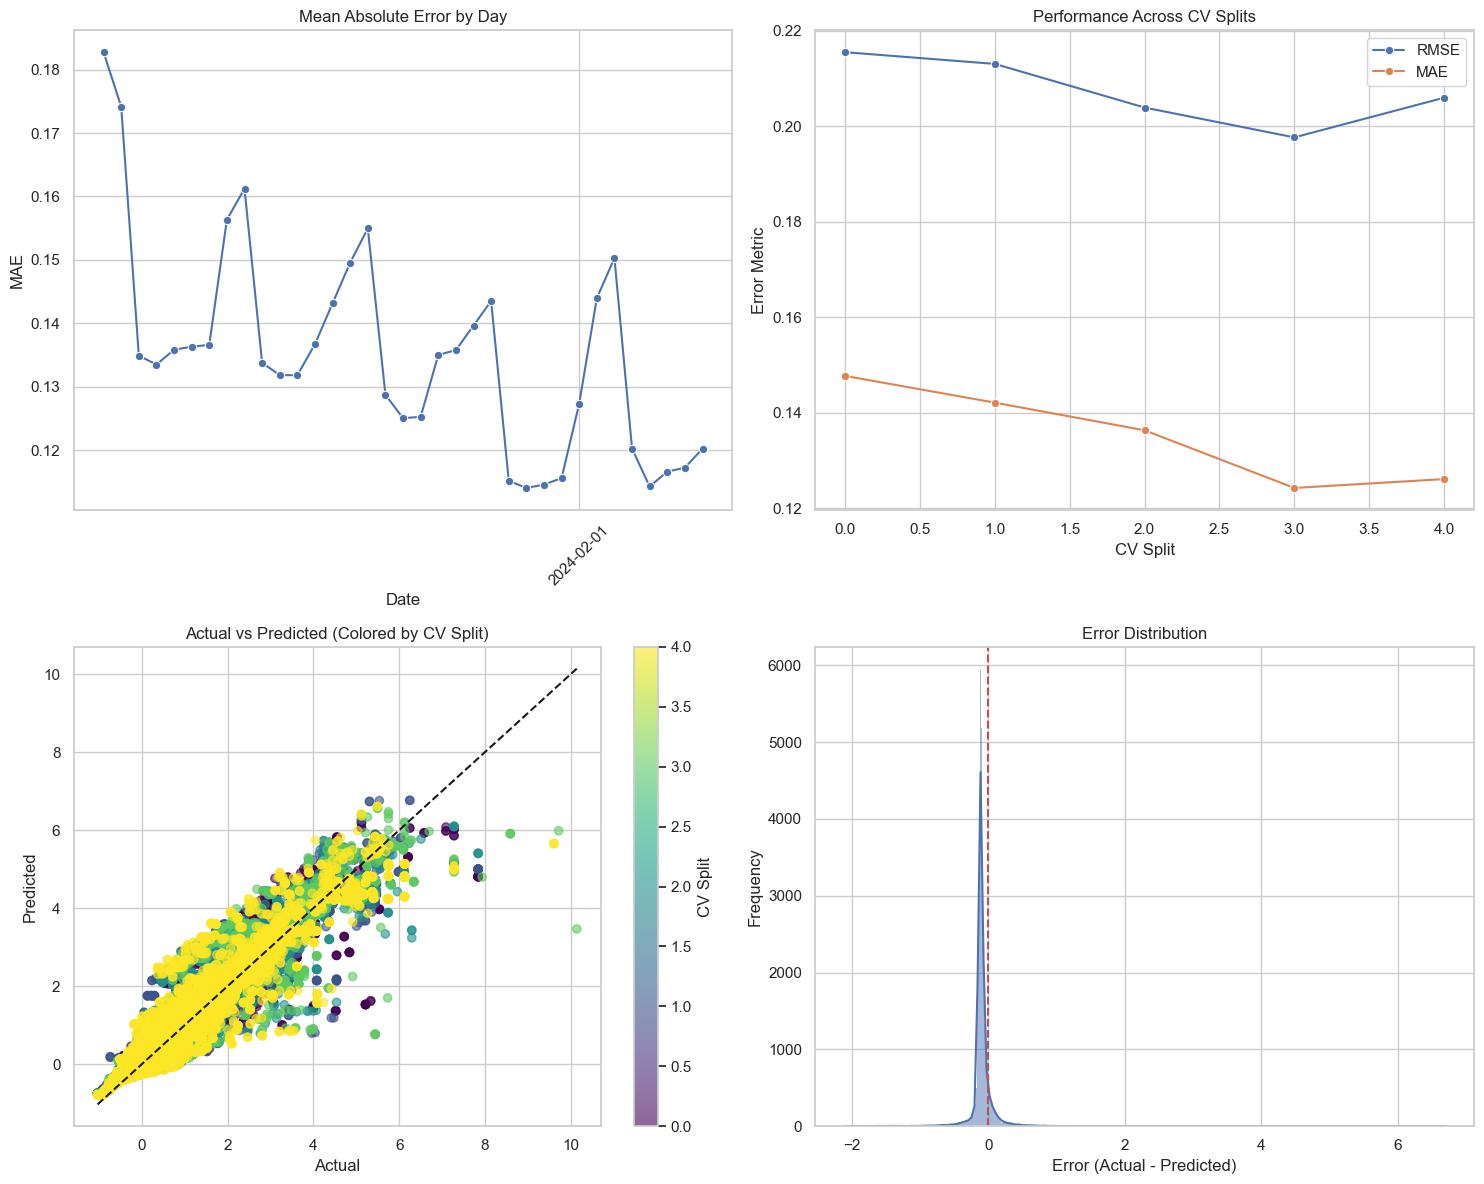

C:\Users\mvk\AppData\Local\Temp\ipykernel_4296\650818108.py:602: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


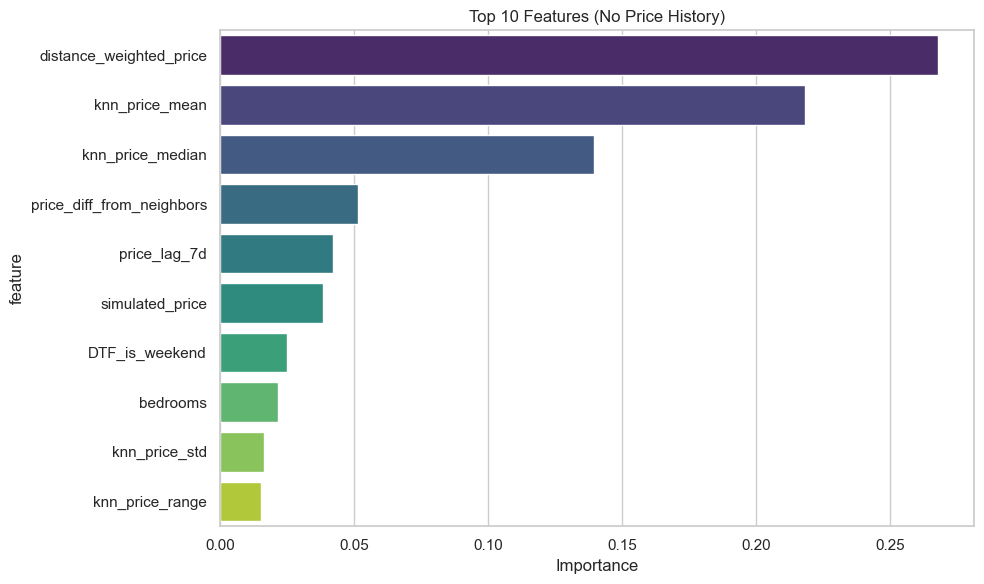

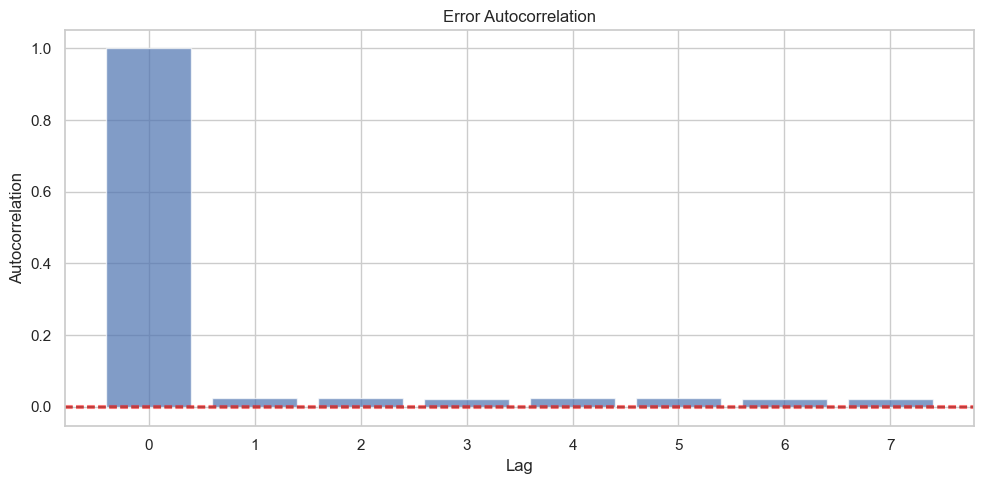

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from math import radians, sin, cos, sqrt, atan2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, median_absolute_error
from scipy.stats import linregress
from statsmodels.tsa.stattools import acf
from sklearn.neighbors import BallTree
from xgboost import XGBRegressor
from joblib import Parallel, delayed
import math
import warnings
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit

def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points using the Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def create_spatial_features(df, k_neighbors=5, chunk_size=1000, n_jobs=-1):
    """Enhanced spatial features while maintaining existing structure"""
    # Adjust k_neighbors if the dataset is small
    actual_k = min(k_neighbors, len(df) - 1)  # Make sure k is at most n-1
    if actual_k < k_neighbors:
        print(f"Reducing k_neighbors from {k_neighbors} to {actual_k} due to small sample size")
    
    city_center_lat, city_center_lon = 48.8566, 2.3522
    
    # Keep existing spatial features
    spatial_data = {
        'distance_to_center': [],
        'north_south': [],
        'knn_price_mean': [],
        'knn_price_std': [],
        'price_diff_from_neighbors': []
    }
    
    # Add new spatial features
    spatial_data.update({
        'knn_price_median': [],  # Add median as more robust metric
        'knn_price_range': [],   # Add price range in neighborhood
        'distance_weighted_price': []  # Add distance-weighted price
    })
    
    # Calculate basic distance features (keeping existing logic)
    spatial_data['distance_to_center'] = df.apply(
        lambda row: calculate_distance(
            row['latitude'], 
            row['longitude'], 
            city_center_lat, 
            city_center_lon
        ),
        axis=1
    ).values
    
    spatial_data['north_south'] = (df['latitude'] - city_center_lat).values
    
    # Enhanced BallTree processing
    all_coords = np.radians(df[['latitude', 'longitude']].values)
    tree = BallTree(all_coords, metric='haversine')
    all_prices = df['price'].values
    
    def enhanced_process_chunk(chunk_data, tree, k_neighbors, all_prices):
        """Enhanced chunk processing with additional metrics"""
        coords = np.radians(chunk_data[['latitude', 'longitude']].values)
        # Use adaptive k value
        k_query = min(k_neighbors + 1, len(all_coords))
        distances, indices = tree.query(coords, k=k_query)
        
        # If k_query is 1, we need special handling
        if k_query == 1:
            # Just return zeros or appropriate values for a single point
            n_samples = len(chunk_data)
            return {
                'knn_price_mean': np.zeros(n_samples),
                'knn_price_std': np.zeros(n_samples),
                'knn_price_median': np.zeros(n_samples),
                'knn_price_range': np.zeros(n_samples),
                'price_diff_from_neighbors': np.zeros(n_samples),
                'distance_weighted_price': np.zeros(n_samples)
            }
        
        # Process neighbor data if we have multiple points
        # Handle the case where k_query is 2 (self + 1 neighbor)
        if k_query == 2:
            neighbor_prices = np.take(all_prices, indices[:, 1:]).reshape(-1, 1)
            weights = np.ones((len(distances), 1))  # Only one neighbor, so weight is 1
        else:
            # Convert distances to weights (inverse distance weighting)
            weights = 1 / (distances[:, 1:] + 1e-6)  # Add small epsilon to avoid division by zero
            weights = weights / weights.sum(axis=1, keepdims=True)
            neighbor_prices = np.take(all_prices, indices[:, 1:])
        
        # Calculate neighbor statistics
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)  # Ignore NaN warnings
            mean_prices = np.nanmean(neighbor_prices, axis=1)
            std_prices = np.nanstd(neighbor_prices, axis=1)
            
            # Handle single-neighbor case for median and range
            if neighbor_prices.shape[1] == 1:
                median_prices = neighbor_prices.flatten()
                range_prices = np.zeros(len(neighbor_prices))
            else:
                median_prices = np.nanmedian(neighbor_prices, axis=1)
                range_prices = np.ptp(neighbor_prices, axis=1)
            
            # Weighted prices
            if neighbor_prices.shape[1] == 1:
                weighted_prices = neighbor_prices.flatten()
            else:
                weighted_prices = np.sum(weights * neighbor_prices, axis=1)
        
        return {
            'knn_price_mean': mean_prices,
            'knn_price_std': std_prices,
            'knn_price_median': median_prices,
            'knn_price_range': range_prices,
            'price_diff_from_neighbors': chunk_data['price'].values - mean_prices,
            'distance_weighted_price': weighted_prices
        }
    
    # Split and process chunks (keeping existing logic)
    n_chunks = math.ceil(len(df) / chunk_size)
    chunks = np.array_split(df, n_chunks)
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(enhanced_process_chunk)(
            chunk, 
            tree, 
            actual_k,  # Use adjusted k value
            all_prices
        ) for chunk in chunks
    )
    
    # Combine results with new features
    for key in spatial_data.keys():
        if key not in ['distance_to_center', 'north_south']:
            spatial_data[key] = np.concatenate([r[key] for r in results])
    
    spatial_features = pd.DataFrame(spatial_data, index=df.index)
    
    # Enhanced feature standardization
    features_to_standardize = list(spatial_data.keys())
    
    for col in features_to_standardize:
        mean_val = spatial_features[col].mean()
        std_val = spatial_features[col].std()
        # Avoid division by zero
        if std_val > 0:
            spatial_features[col] = (spatial_features[col] - mean_val) / std_val
        else:
            spatial_features[col] = 0  # Set to zero if std is zero
    
    return spatial_features

def run_rolling_window_xgboost(train_path, output_dir=None, window_size=35, n_splits=5, sample_size=None):
    """
    Run XGBoost with rolling window cross-validation for predicting prices without price history.
    
    Parameters:
    -----------
    train_path : str
        Path to the Topic2_Train.csv file
    output_dir : str, optional
        Directory to save results
    window_size : int, optional
        Size of the rolling window in days
    n_splits : int, optional
        Number of splits for time series cross-validation
    sample_size : int, optional
        Limit dataset to this number of random listings (for testing)
    """
    print(f"Processing dataset: {os.path.basename(train_path)}")
    
    # Load training data
    print("Loading data...")
    train_data = pd.read_csv(train_path)

    # Drop the price_lag_1d column if it exists
    if 'price_lag_1d' in train_data.columns:
        print("Dropping price_lag_1d column from the dataset")
        train_data = train_data.drop('price_lag_1d', axis=1)
    
    # For testing - take only a small sample of listings if specified
    if sample_size:
        unique_listings = train_data['listing_id'].unique()
        if len(unique_listings) > sample_size:
            print(f"Limiting to {sample_size} random listings for testing")
            selected_listings = np.random.choice(unique_listings, sample_size, replace=False)
            train_data = train_data[train_data['listing_id'].isin(selected_listings)]
    
    # Convert date column to datetime
    train_data['date'] = pd.to_datetime(train_data['date'])
    
    # Filter data to include only dates from 8/7/23 till 8/2/24 (as specified)
    start_date = pd.to_datetime('2023-07-08')
    end_date = pd.to_datetime('2024-02-08')
    train_data = train_data[(train_data['date'] >= start_date) & (train_data['date'] <= end_date)]
    
    # In the run_rolling_window_xgboost function, after you load and filter the data:

    # Check if we have data for the entire expected range
    print(f"Date range in filtered data: {train_data['date'].min()} to {train_data['date'].max()}")
    print(f"Number of days with data: {len(train_data['date'].dt.date.unique())}")

    # Get unique dates and ensure they are properly sorted
    unique_dates = sorted(train_data['date'].dt.date.unique())
    first_date = unique_dates[0]
    last_date = unique_dates[-1]

    # Check if there's a gap between the expected start date and actual first date
    if first_date > start_date.date():
        print(f"Warning: No data found between {start_date.date()} and {first_date}")
        print(f"Using available data starting from {first_date}")


    train_data['date'] = pd.to_datetime(train_data['date'])
    
    # Filter data to include only dates from 7/8/23 till 8/2/24 (as specified)
    start_date = pd.to_datetime('2023-07-08')
    end_date = pd.to_datetime('2024-02-08')
    train_data = train_data[(train_data['date'] >= start_date) & (train_data['date'] <= end_date)]
    
    # Sort by date
    train_data = train_data.sort_values('date')
    
    print(f"Date range in filtered data: {train_data['date'].min()} to {train_data['date'].max()}")
    
    # Get unique dates
    unique_dates = sorted(train_data['date'].dt.date.unique())
    print(f"Dataset contains {len(unique_dates)} unique dates from {unique_dates[0]} to {unique_dates[-1]}")
    
    # Create explicit test periods - last 5 weeks (35 days) split into 5 equal parts (7 days each)
    last_35_days = unique_dates[-35:]
    
    # Define explicit test periods - each 7 days
    test_periods = []
    for i in range(n_splits):
        start_idx = i * 7
        end_idx = start_idx + 7
        # Make sure we don't go beyond the available data
        if end_idx <= len(last_35_days):
            test_periods.append((last_35_days[start_idx], last_35_days[end_idx-1]))
    
    # Adjust n_splits if we couldn't create enough test periods
    n_splits = len(test_periods)
    
    print(f"Created {n_splits} test periods:")
    for i, (test_start, test_end) in enumerate(test_periods):
        print(f"  Period {i+1}: {test_start} to {test_end}")
    
    # Initialize XGBoost model
    xgb_model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.01,
        max_depth=6,
        min_child_weight=2,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        early_stopping_rounds=20,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1,
        tree_method='hist',
        grow_policy='lossguide'
    )
    
    # Storage for results
    cv_results = []
    feature_importance_over_time = []
    
    # Run time series cross-validation using our explicit test periods
    for i, (test_start, test_end) in enumerate(test_periods):
        print(f"\nSplit {i+1}/{n_splits}")
        
        # Define training period: everything before test_start
        train_end = pd.to_datetime(test_start) - pd.Timedelta(days=1)
        train_end_date = train_end.date()
        
        print(f"Training period: {unique_dates[0]} to {train_end_date}")
        print(f"Testing period: {test_start} to {test_end}")
        
        # Get corresponding data
        train_mask = train_data['date'].dt.date <= train_end_date
        test_mask = (train_data['date'].dt.date >= test_start) & (train_data['date'].dt.date <= test_end)
        
        split_train_data = train_data[train_mask]
        split_test_data = train_data[test_mask]
        
        # Create spatial features for training and test data
        train_spatial = create_spatial_features(split_train_data)
        test_spatial = create_spatial_features(split_test_data)
        
        # Prepare feature matrices
        X_train = pd.concat([
            split_train_data.drop(['listing_id', 'date', 'price'], axis=1), 
            train_spatial
        ], axis=1)
        
        X_test = pd.concat([
            split_test_data.drop(['listing_id', 'date', 'price'], axis=1), 
            test_spatial
        ], axis=1)
        
        y_train = split_train_data['price']
        y_test = split_test_data['price']
        
        # Ensure X_train and X_test have the same columns
        missing_cols = set(X_train.columns) - set(X_test.columns)
        for col in missing_cols:
            X_test[col] = 0
            
        # Ensure the columns are in the same order
        X_test = X_test[X_train.columns]
        
        # Train the model
        print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples")
        xgb_model.fit(
            X_train, 
            y_train,
            eval_set=[(X_test, y_test)],
            verbose=False
        )
        
        # Make predictions
        y_pred = xgb_model.predict(X_test)
        
        # Store feature importance
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': xgb_model.feature_importances_,
            'split': i
        })
        feature_importance_over_time.append(feature_importance)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred) if len(set(y_test)) > 1 else np.nan
        with np.errstate(divide='ignore', invalid='ignore'):
            mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
        
        print(f"Split {i+1} Results - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")
        
        # Store results for this split
        split_results = pd.DataFrame({
            'split': i,
            'date': split_test_data['date'],
            'listing_id': split_test_data['listing_id'],
            'price': y_test,
            'predicted': y_pred,
            'error': y_test - y_pred,
            'abs_error': np.abs(y_test - y_pred),
            'pct_error': np.abs((y_test - y_pred) / (y_test + 1e-8)) * 100
        })
        
        cv_results.append(split_results)
    
    # Combine all results
    all_results = pd.concat(cv_results, ignore_index=True)
    all_feature_importance = pd.concat(feature_importance_over_time, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['price']
    y_pred = all_results['predicted']
    
    overall_metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100,
        'explained_variance': explained_variance_score(y_true, y_pred),
        'max_error': max_error(y_true, y_pred),
        'median_absolute_error': median_absolute_error(y_true, y_pred)
    }
    
    # Calculate split-level metrics
    split_metrics = []
    for split in range(n_splits):
        split_data = all_results[all_results['split'] == split]
        if not split_data.empty:
            y_true_split = split_data['price']
            y_pred_split = split_data['predicted']
            
            split_metrics.append({
                'split': split,
                'rmse': np.sqrt(mean_squared_error(y_true_split, y_pred_split)),
                'mae': mean_absolute_error(y_true_split, y_pred_split),
                'r2': r2_score(y_true_split, y_pred_split) if len(set(y_true_split)) > 1 else np.nan,
                'mape': np.mean(np.abs((y_true_split - y_pred_split) / (y_true_split + 1e-8))) * 100,
                'n_samples': len(y_true_split)
            })
    
    split_metrics_df = pd.DataFrame(split_metrics)
    
    # Calculate daily metrics
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
    
    daily_metrics = []
    for day, group in all_results.groupby('date_str'):
        y_true_day = group['price']
        y_pred_day = group['predicted']
        
        daily_metrics.append({
            'date': day,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (y_true_day + 1e-8))) * 100,
            'n_samples': len(y_true_day)
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    daily_metrics_df['date'] = pd.to_datetime(daily_metrics_df['date'])
    daily_metrics_df = daily_metrics_df.sort_values('date')
    
    # Error analysis
    errors = all_results['error'].values
    error_autocorr = acf(errors, nlags=7)[1:]  # Exclude lag 0
    
    # Create a results dictionary
    evaluation_results = {
        'overall_metrics': overall_metrics,
        'split_metrics': split_metrics_df,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results,
        'feature_importance': all_feature_importance,
        'error_autocorrelation': error_autocorr
    }
    
    # Save results if output directory is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        
        # Save all results
        results_file = os.path.join(output_dir, 'xgboost_rolling_window_results.csv')
        all_results.to_csv(results_file, index=False)
        print(f"Results saved to {results_file}")
        
        # Save metrics
        metrics_file = os.path.join(output_dir, 'xgboost_rolling_window_metrics.csv')
        daily_metrics_df.to_csv(metrics_file, index=False)
        print(f"Daily metrics saved to {metrics_file}")
        
        # Save feature importance
        importance_file = os.path.join(output_dir, 'xgboost_rolling_window_feature_importance.csv')
        all_feature_importance.to_csv(importance_file, index=False)
        print(f"Feature importance saved to {importance_file}")
        
        # Save summary
        with open(os.path.join(output_dir, 'summary.txt'), 'w') as f:
            f.write(f"XGBoost Rolling Window CV Model Summary\n")
            f.write(f"=====================================\n\n")
            f.write(f"Window size: {window_size} days\n")
            f.write(f"Number of splits: {n_splits}\n")
            f.write(f"Training period: {unique_dates[0]} to {unique_dates[-1]}\n\n")
            f.write(f"Overall Metrics:\n")
            for k, v in overall_metrics.items():
                f.write(f"  {k}: {v:.6f}\n")
    
    # Print summary
    print_rolling_window_summary(evaluation_results)
    
    # Create plots
    plot_rolling_window_results(evaluation_results)
    
    return evaluation_results

def print_rolling_window_summary(evaluation_results):
    """Print a summary of rolling window cross-validation results"""
    overall = evaluation_results['overall_metrics']
    splits = evaluation_results['split_metrics']
    daily = evaluation_results['daily_metrics']
    feature_importance = evaluation_results['feature_importance']
    error_autocorr = evaluation_results.get('error_autocorrelation', [0] * 7)
    
    print("\n===== ROLLING WINDOW XGBOOST MODEL EVALUATION (WITHOUT PRICE HISTORY) =====")
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    print(f"Explained Variance: {overall['explained_variance']:.4f}")
    print(f"Median Abs Error: {overall['median_absolute_error']:.4f}")
    
    print("\n=== Split Performance ===")
    print(splits[['split', 'rmse', 'mae', 'mape', 'r2', 'n_samples']].to_string(index=False))
    
    print("\n=== Split Statistics ===")
    print("MAE:")
    print(f"  Average: {splits['mae'].mean():.4f}")
    print(f"  Min: {splits['mae'].min():.4f} (Split {splits.loc[splits['mae'].idxmin(), 'split']})")
    print(f"  Max: {splits['mae'].max():.4f} (Split {splits.loc[splits['mae'].idxmax(), 'split']})")
    
    print("\nRMSE:")
    print(f"  Average: {splits['rmse'].mean():.4f}")
    print(f"  Min: {splits['rmse'].min():.4f} (Split {splits.loc[splits['rmse'].idxmin(), 'split']})")
    print(f"  Max: {splits['rmse'].max():.4f} (Split {splits.loc[splits['rmse'].idxmax(), 'split']})")
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    # Calculate overall feature importance by averaging across splits
    avg_importance = feature_importance.groupby('feature')['importance'].mean().reset_index()
    top_features = avg_importance.sort_values('importance', ascending=False).head(10)
    
    print("\n=== Top 10 Most Important Features (No Price History) ===")
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"{i}. {row['feature']}: {row['importance']:.6f}")

def plot_rolling_window_results(evaluation_results):
    """Plot the results from rolling window cross-validation"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    splits = evaluation_results['split_metrics']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[0, 0].xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Cross-validation splits performance
    splits_x = splits['split']
    metrics_to_plot = ['rmse', 'mae']
    
    for metric in metrics_to_plot:
        sns.lineplot(
            x=splits_x,
            y=splits[metric],
            marker='o',
            label=metric.upper(),
            ax=axes[0, 1]
        )
    
    axes[0, 1].set_title('Performance Across CV Splits')
    axes[0, 1].set_xlabel('CV Split')
    axes[0, 1].set_ylabel('Error Metric')
    axes[0, 1].legend()
    
    # Plot 3: Actual vs Predicted (colored by split)
    scatter = axes[1, 0].scatter(
        all_results['price'],
        all_results['predicted'],
        c=all_results['split'],
        alpha=0.6,
        cmap='viridis'
    )
    min_val = min(all_results['price'].min(), all_results['predicted'].min())
    max_val = max(all_results['price'].max(), all_results['predicted'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 0].set_title('Actual vs Predicted (Colored by CV Split)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[1, 0])
    cbar.set_label('CV Split')
    
    # Plot 4: Error distribution
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title('Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Create plot for feature importance
    feature_importance = evaluation_results['feature_importance']
    top_features = feature_importance.groupby('feature')['importance'].mean().nlargest(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=top_features.values,
        y=top_features.index,
        palette='viridis'
    )
    plt.title('Top 10 Features (No Price History)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    # Plot error autocorrelation
    error_acf = np.concatenate([[1], evaluation_results['error_autocorrelation']])
    lags = range(len(error_acf))
    
    plt.figure(figsize=(10, 5))
    plt.bar(lags, error_acf, alpha=0.7)
    plt.axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals (95%)
    conf_interval = 1.96 / np.sqrt(len(all_results['error']))
    plt.axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    plt.axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Error Autocorrelation')
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Path to Topic2_Train.csv
    train_path = r"C:\Users\mvk\Documents\DATA_school\thesis\Subset\top_price_changers_subset\train2_with_lags.csv"
    
    # Output directory
    output_dir = r"C:\Users\mvk\Documents\DATA_school\thesis\Output\Xgboost\Topic2_RollingWindow"
    
    # Run the model
    results = run_rolling_window_xgboost(
        train_path=train_path,
        output_dir=output_dir,
        window_size=35,  # 5 weeks
        n_splits=5,
        sample_size=None  # Set to a number like 1000 for testing, None to use all data
    )